Используем устройство: cuda
Найдено 72 изображений.


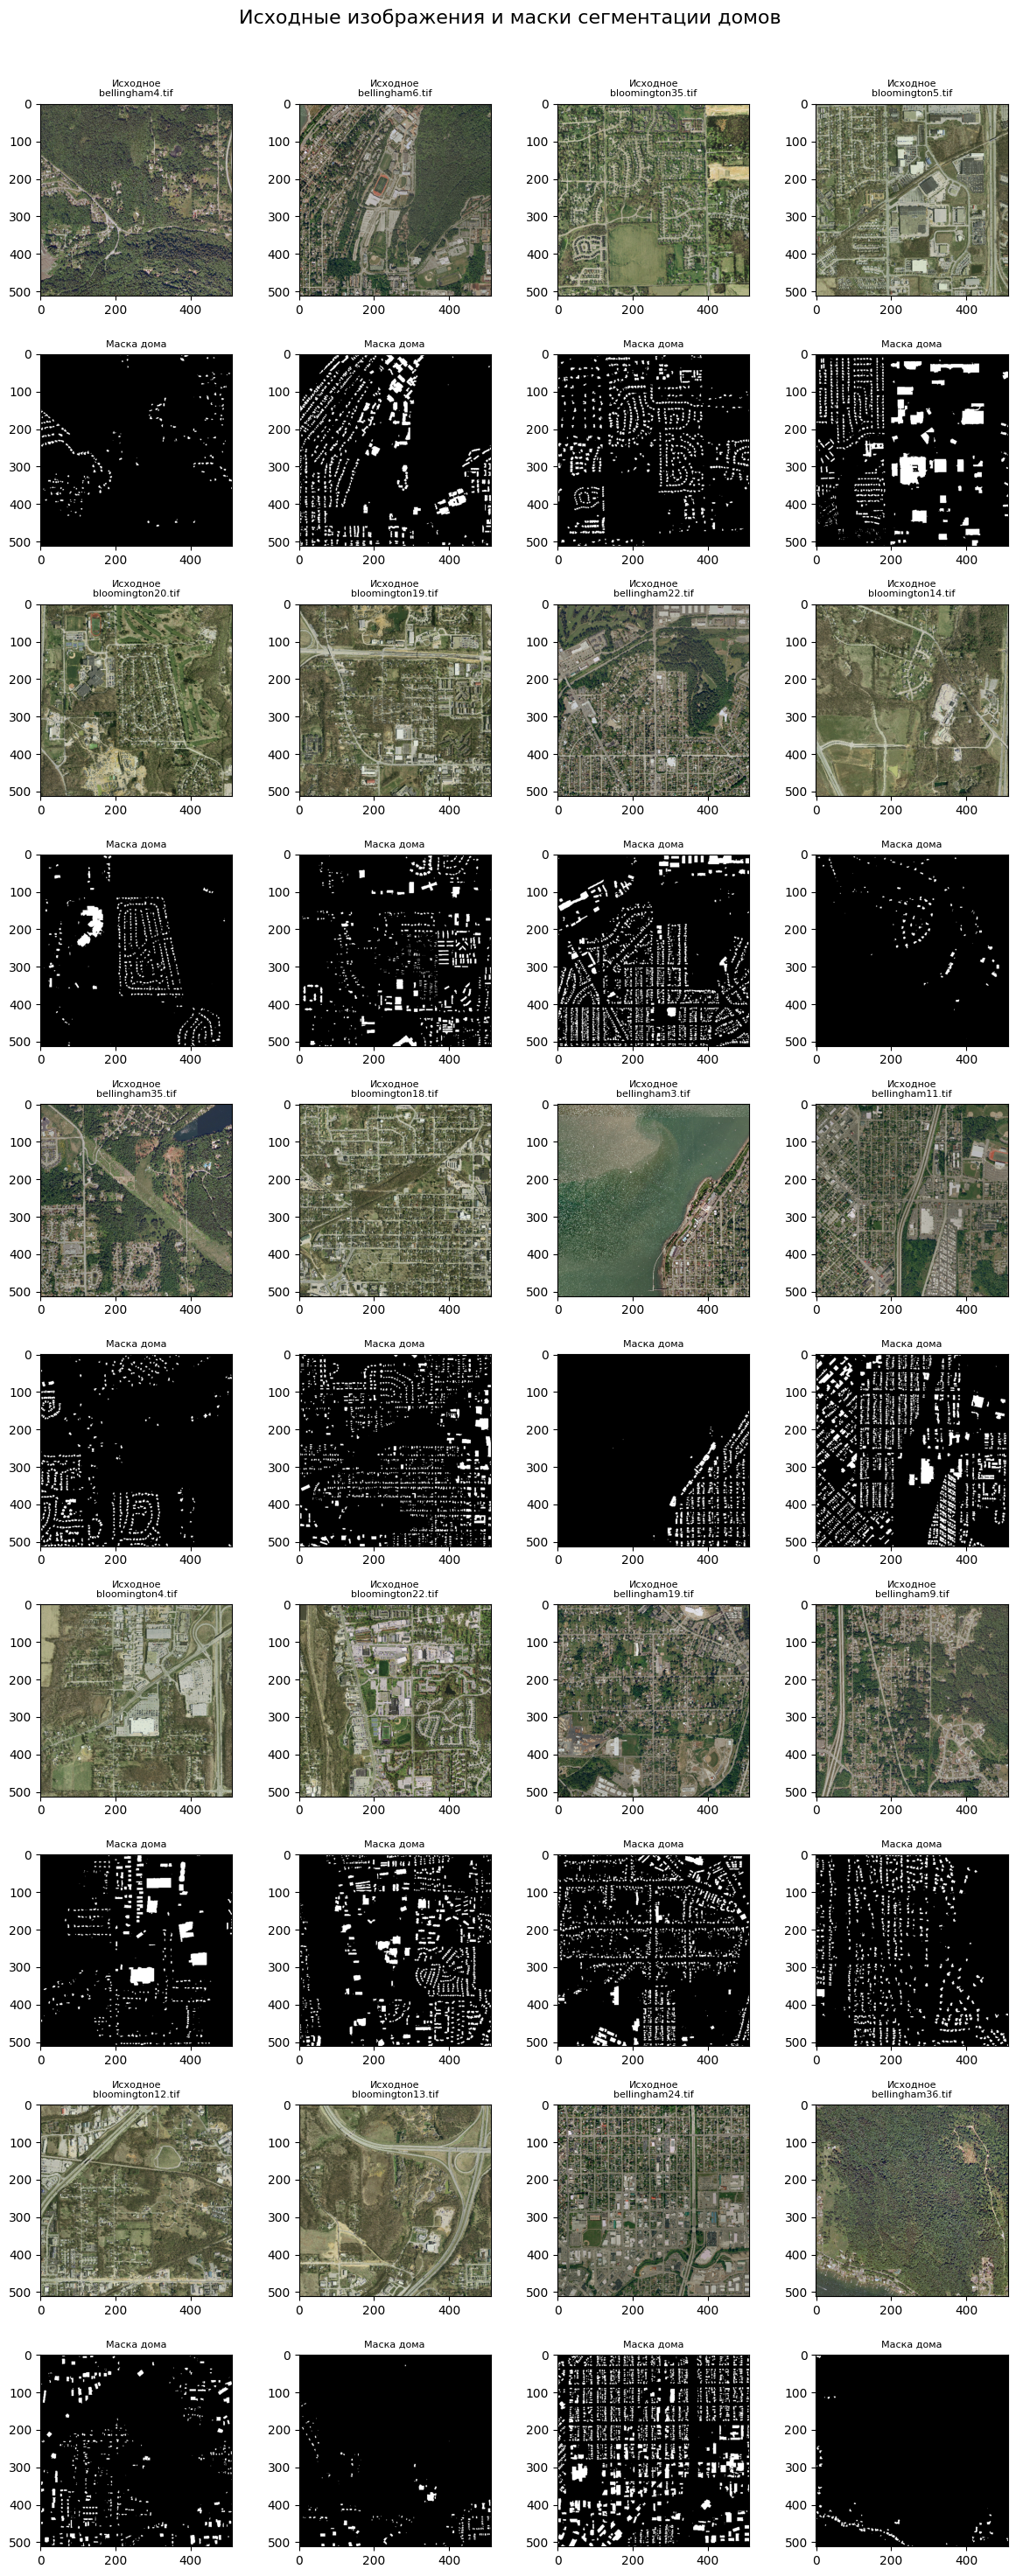

In [4]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from pathlib import Path

# ----------------------------
# 1. Определение модели (должно совпадать с обученной)
# ----------------------------

from torchvision.models import resnet18, ResNet18_Weights

class UNetResNet18(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1
        encoder = resnet18(weights=weights)
        
        self.enc0 = nn.Sequential(encoder.conv1, encoder.bn1, encoder.relu)
        self.pool = encoder.maxpool
        self.enc1 = encoder.layer1
        self.enc2 = encoder.layer2
        self.enc3 = encoder.layer3
        self.enc4 = encoder.layer4

        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder4 = self._conv_block(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = self._conv_block(256, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = self._conv_block(128, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.decoder1 = self._conv_block(128, 64)
        self.upconv0 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder0 = self._conv_block(32, 32)
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)

    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        e0 = self.enc0(x)
        x = self.pool(e0)
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        d4 = self.decoder4(torch.cat([self.upconv4(e4), e3], dim=1))
        d3 = self.decoder3(torch.cat([self.upconv3(d4), e2], dim=1))
        d2 = self.decoder2(torch.cat([self.upconv2(d3), e1], dim=1))
        d1 = self.decoder1(torch.cat([self.upconv1(d2), e0], dim=1))
        d0 = self.decoder0(self.upconv0(d1))
        return self.final(d0)

# ----------------------------
# 2. Загрузка модели
# ----------------------------

def load_model(model_path="house_segmentation_model.pth", device="cpu"):
    model = UNetResNet18(num_classes=1)
    # Загружаем веса на нужное устройство
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)  
    model.eval()
    return model

# ----------------------------
# 3. Инференс на большом изображении
# ----------------------------

def predict_full_image(model, image_bgr, tile_size=512, device="cpu"):
    h, w = image_bgr.shape[:2]
    mask = np.zeros((h, w), dtype=np.float32)

    with torch.no_grad():
        for y in range(0, h, tile_size):
            for x in range(0, w, tile_size):
                y_end = min(y + tile_size, h)
                x_end = min(x + tile_size, w)
                tile = image_bgr[y:y_end, x:x_end]

                pad_h = tile_size - tile.shape[0]
                pad_w = tile_size - tile.shape[1]
                if pad_h > 0 or pad_w > 0:
                    tile = np.pad(tile, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')

                tile_tensor = torch.from_numpy(tile).permute(2, 0, 1).float() / 255.0
                tile_tensor = tile_tensor.unsqueeze(0).to(device)

                output = model(tile_tensor)
                prob = torch.sigmoid(output)[0, 0].cpu().numpy()

                # Обрезаем паддинг
                prob = prob[:y_end - y, :x_end - x]
                mask[y:y_end, x:x_end] = prob

    # Бинаризация
    return (mask > 0.5).astype(np.uint8) * 255

# ----------------------------
# 4. Основной скрипт
# ----------------------------

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Используем устройство: {device}")

    # Загрузка модели
    model = load_model("house_segmentation_model.pth", device=device)

    # Путь к тестовым изображениям
    test_dir = Path("Data/test/images")
    if not test_dir.exists():
        raise FileNotFoundError(f"Папка не найдена: {test_dir}")

    image_paths = list(test_dir.glob("*.*"))
    image_paths = [p for p in image_paths if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".tif", ".tiff"}]

    if not image_paths:
        raise FileNotFoundError(f"Не найдено изображений в {test_dir}")

    print(f"Найдено {len(image_paths)} изображений.")

    # Выбираем 20 случайных (или все, если <20)
    selected_paths = random.sample(image_paths, min(20, len(image_paths)))

    # Подготовка графика
    n = len(selected_paths)
    cols = 4
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows * 2, cols, figsize=(cols * 3, rows * 2 * 3))
    fig.suptitle("Исходные изображения и маски сегментации домов", fontsize=16)

    # Скрыть все оси по умолчанию
    for ax in axes.flat:
        ax.axis('off')

    for idx, img_path in enumerate(selected_paths):
        # Загрузка изображения
        img_bgr = cv2.imread(str(img_path))
        if img_bgr is None:
            print(f"Пропущено: {img_path}")
            continue

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # Предсказание
        mask = predict_full_image(model, img_bgr, tile_size=1024, device=device)

        # Нормализация для отображения
        orig_display = cv2.resize(img_rgb, (512, 512)) if max(img_rgb.shape) > 512 else img_rgb
        mask_display = cv2.resize(mask, (512, 512)) if max(mask.shape) > 512 else mask

        # Позиции на сетке
        row_orig = (idx // cols) * 2
        row_mask = row_orig + 1
        col = idx % cols

        axes[row_orig, col].imshow(orig_display)
        axes[row_orig, col].set_title(f"Исходное\n{img_path.name}", fontsize=8)
        axes[row_orig, col].axis('on')

        axes[row_mask, col].imshow(mask_display, cmap='gray')
        axes[row_mask, col].set_title("Маска дома", fontsize=8)
        axes[row_mask, col].axis('on')

    total_subplots = rows * 2 * cols
    used_subplots = n * 2
    for i in range(used_subplots, total_subplots):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()